In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

# Data processing

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import pickle
import torch
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [3]:
# define some funtions
def split_date(data: DataFrame, col: str):
    """
    拆分时间
    :param data:需要拆分的数据
    :param col: 时间所在的列
    :return: DataFrame
    """
    data['year'] = data[col].apply(lambda x: x.year)
    data['month'] = data[col].apply(lambda x: x.month)
    data['day'] = data[col].apply(lambda x: x.day)
    data['hour'] = data[col].apply(lambda x: x.hour)
    return data

def merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station):
    """处理train数据"""
    if 'datetime' in train.columns:
        pass
    else:
        train.rename(columns={'prediction_datetime': 'datetime'}, inplace=True)
    train = split_date(train, 'datetime')  # 拆分时间

    """处理train_history数据"""
    train_history['datetime'] = train_history['datetime'].apply(lambda x: x + pd.Timedelta(2, 'D'))
    train_history.rename(columns={'target': 'target_used'}, inplace=True)

    """处理client数据"""
    client['datetime'] = client['date'].apply(lambda x: x+pd.Timedelta(2, 'D'))  # 将day向前移两天
    client = split_date(client, 'datetime')
    client.drop(columns=['hour', 'datetime', 'date'], inplace=True)

    """处理gas_prices数据"""
    gas_prices['datetime'] = gas_prices['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    gas_prices = split_date(gas_prices, 'datetime')
    gas_prices.drop(columns=['datetime', 'forecast_date', 'hour'], inplace=True)

    """处理electricity数据"""
    electricity['datetime'] = electricity['forecast_date'].apply(lambda x: x + pd.Timedelta(1, 'D'))
    electricity.drop(columns=['forecast_date'], inplace=True)

    """处理historical_weather数据"""
    historical_weather['datetime'] = historical_weather['datetime'].apply(lambda x: x + pd.Timedelta(37, 'H'))
    historical_weather['latitude'] = historical_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    historical_weather['longitude'] = historical_weather['longitude'].astype(float)
    historical_weather.loc[:, 'latitude'] = historical_weather.loc[:, 'latitude'].round(1)   # 将经纬度取一位小数
    historical_weather.loc[:, 'longitude'] = historical_weather.loc[:, 'longitude'].round(1)
    station['latitude'] = station['latitude'].astype(float)
    station['longitude'] = station['longitude'].astype(float)
    station.loc[:, 'longitude'] = station.loc[:, 'longitude'].round(1)
    station.loc[:, 'latitude'] = station.loc[:, 'latitude'].round(1)
    # 与station数据按照经纬度和时间拼接
    historical_weather = pd.merge(left=historical_weather, right=station, how='left', on=['latitude', 'longitude'])
    # historical_weather.dropna(subset='county', inplace=True)
    historical_weather.drop(columns=['latitude', 'longitude'], inplace=True)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    historical_weather = historical_weather.groupby(by=['datetime', 'county']).mean()

    """处理forecast_weather数据"""
    forecast_weather = forecast_weather[forecast_weather['hours_ahead'] >= 24]
    forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
    forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)
    forecast_weather.loc[:, 'longitude'] = forecast_weather.loc[:, 'longitude'].round(1)
    forecast_weather.loc[:, 'latitude'] = forecast_weather.loc[:, 'latitude'].round(1)
    forecast_weather = pd.merge(left=forecast_weather, right=station, on=['latitude', 'longitude'])
    # 去除缺失值以及删除无用列
    # forecast_weather.dropna(subset='county', inplace=True)
    forecast_weather.drop(
        columns=['latitude', 'longitude', 'hours_ahead'],
        inplace=True)
    # 将forecast列索引重命名，以防止合并后与historical重名
    forecast_cols_new = {}
    forecast_cols = forecast_weather.columns
    for index in forecast_cols:
        if index == 'forecast_datetime':
            index_new = 'datetime'
        elif index == 'county':
            index_new = index
        else:
            index_new = str(index) + '_fw'
        forecast_cols_new[index] = index_new
    forecast_weather.rename(columns=forecast_cols_new, inplace=True)
    # 去除时间UTC值
    forecast_weather['datetime'] = pd.to_datetime(forecast_weather.datetime).dt.tz_localize(None)
    # 由于一个county对应多个天气站点，将同一个county同一时间的数据平均
    forecast_weather = forecast_weather.groupby(by=['datetime', 'county']).mean()

    """开始拼接数据"""
    data = pd.merge(left=train, right=train_history, how='left', on=['datetime', 'county', 'is_business', 'product_type',
                                                                     'is_consumption'])
    data = pd.merge(left=data, right=client, how='left', on=['product_type', 'county',
                                                             'is_business', 'year', 'month', 'day'])
    data = pd.merge(left=data, right=gas_prices, how='left', on=['year', 'month', 'day'])
    data = pd.merge(left=data, right=electricity, how='left', on='datetime')
    data = pd.merge(left=data, right=historical_weather, how='left', on=['datetime', 'county'])
    data = pd.merge(left=data, right=forecast_weather, how='left', on=['datetime', 'county'])

    return data

def load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station, is_train=True):
    """加载数据"""
    data = merge_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather,
                      station)
    # 删除多余列
    data.drop(columns=['datetime'], inplace=True)
    # one-hot编码
    data = pd.get_dummies(data, columns=['is_business', 'product_type', 'is_consumption'], dtype=float)
    # 生成nparray数组
    if is_train:
        # 删除缺失值
        data.dropna(subset=['target'], inplace=True)
        X = data.drop(columns=['row_id', 'target'])
        features = list(X.columns)
        X = np.array(X)
        print('X.shape', X.shape)
        Y = data['target']
        Y = np.array(Y)
        output = (features, X, Y)
        with open("train_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    else:
        X = data.drop(columns=['row_id'])
        X = np.array(X)
        print('X.shape', X.shape)
        output = X
        with open("test_data.pkl", 'wb') as f:
            pickle.dump(output, f)
    return output

def make_train_test(X, Y, seed, rate):
    """划分训练集和测试集，并且打乱"""
    idx = int(rate * X.shape[0])
    X_train = X[:idx]
    Y_train = Y[:idx]
    X_test = X[idx:]
    Y_test = Y[idx:]
    shuffled_indices = np.arange(X_train.shape[0])
    np.random.seed(seed)
    np.random.shuffle(shuffled_indices)
    X_train, Y_train = X_train[shuffled_indices], Y_train[shuffled_indices]
    return (X_train, Y_train), (X_test, Y_test)

In [4]:
# 未筛选特征所用到的列
train_cols = ['county', 'target', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
test_cols = ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_datetime', 'row_id']
train_history_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
station_cols = ['longitude', 'latitude', 'county']

In [5]:
# 筛选后特征所用到的列
train_cols_selected = ['county', 'target', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
test_cols_selected = ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_datetime', 'row_id']
train_history_cols_selected = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']
client_cols_selected = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols_selected = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols_selected = ['forecast_date', 'euros_per_mwh']
forecast_cols_selected = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_low', 'cloudcover_total', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall']
historical_cols_selected = ['datetime', 'temperature', 'dewpoint', 'snowfall', 'cloudcover_total','cloudcover_low','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
station_cols_selected = ['longitude', 'latitude', 'county']

## Generate unfiltered data

In [6]:
# 生成未筛选训练数据
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv', parse_dates=['datetime'], usecols=train_cols)
train_history = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv', parse_dates=['datetime'], usecols=train_history_cols)
client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv', parse_dates=['date'], usecols=client_cols)
gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv', parse_dates=['forecast_date'], usecols=gas_cols)
electricity = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv', parse_dates=['forecast_date'], usecols=electricity_cols)
historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv', parse_dates=['datetime'],
                                     usecols=historical_cols)
forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv', parse_dates=['forecast_datetime'],
                                   usecols=forecast_cols)
station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv', usecols=station_cols)
features, X, Y = load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station)
# 划分训练集和测试集
(X_train, y_train), (X_test, y_test) = make_train_test(X, Y, 1, 0.7)

/tmp/ipykernel_724/2099679347.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
/tmp/ipykernel_724/2099679347.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)


X.shape (2017824, 45)


## Generate filtered data

In [7]:
# 生成筛选后训练数据
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv', parse_dates=['datetime'], usecols=train_cols_selected)
train_history = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv', parse_dates=['datetime'], usecols=train_history_cols_selected)
client = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv', parse_dates=['date'], usecols=client_cols_selected)
gas_prices = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv', parse_dates=['forecast_date'], usecols=gas_cols_selected)
electricity = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv', parse_dates=['forecast_date'], usecols=electricity_cols_selected)
historical_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv', parse_dates=['datetime'],
                                     usecols=historical_cols_selected)
forecast_weather = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv', parse_dates=['forecast_datetime'],
                                   usecols=forecast_cols_selected)
station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv', usecols=station_cols_selected)
features_sl, X_sl, Y_sl = load_data(train, train_history, client, gas_prices, electricity, historical_weather, forecast_weather, station)
# 划分训练集和测试集
(X_train_sl, y_train_sl), (X_test_sl, y_test_sl) = make_train_test(X_sl, Y_sl, 1, 0.7)

/tmp/ipykernel_724/2099679347.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
/tmp/ipykernel_724/2099679347.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)


X.shape (2017824, 34)


# Model

In [8]:
class Xgb:
    def __init__(self):
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.clf = xgb.XGBRegressor(
                        device = self.device,
                        objective='reg:absoluteerror',
                        n_estimators = 2 if False else 1500,
                        early_stopping_rounds=100
                        )

    def fit(self, X, y, X_test, y_test):
        """训练"""
        self.clf.fit(X = X, y = y, eval_set = [(X, y), (X_test, y_test)],verbose = True)
        print(f'Early stopping on best iteration #{self.clf.best_iteration} with MAE error on validation set of {self.clf.best_score:.2f}')
    
    def predict(self, X_test):
        """预测"""
        output = self.clf.predict(X_test)
        return  output
    
    def importance(self, features, max_num):
        """特征重要性"""
        self.clf.get_booster().feature_names = features
        plot_importance(self.clf, max_num_features=max_num)
        plt.show()

# Train

## Train the model using the unfilterd data

[0]	validation_0-mae:218.22628	validation_1-mae:291.80046
[1]	validation_0-mae:187.38333	validation_1-mae:252.03461
[2]	validation_0-mae:159.07573	validation_1-mae:215.80188
[3]	validation_0-mae:143.51113	validation_1-mae:194.25443
[4]	validation_0-mae:128.41344	validation_1-mae:174.38161
[5]	validation_0-mae:112.91264	validation_1-mae:153.48046
[6]	validation_0-mae:99.77175	validation_1-mae:138.11026
[7]	validation_0-mae:90.79723	validation_1-mae:125.76888
[8]	validation_0-mae:85.42967	validation_1-mae:118.74288
[9]	validation_0-mae:81.92862	validation_1-mae:113.20321
[10]	validation_0-mae:80.23464	validation_1-mae:109.94771
[11]	validation_0-mae:78.17981	validation_1-mae:107.89378
[12]	validation_0-mae:76.63764	validation_1-mae:103.74260
[13]	validation_0-mae:76.03545	validation_1-mae:101.74029
[14]	validation_0-mae:75.51664	validation_1-mae:100.60740
[15]	validation_0-mae:75.34318	validation_1-mae:100.49053
[16]	validation_0-mae:74.87426	validation_1-mae:99.78923
[17]	validation_0-m

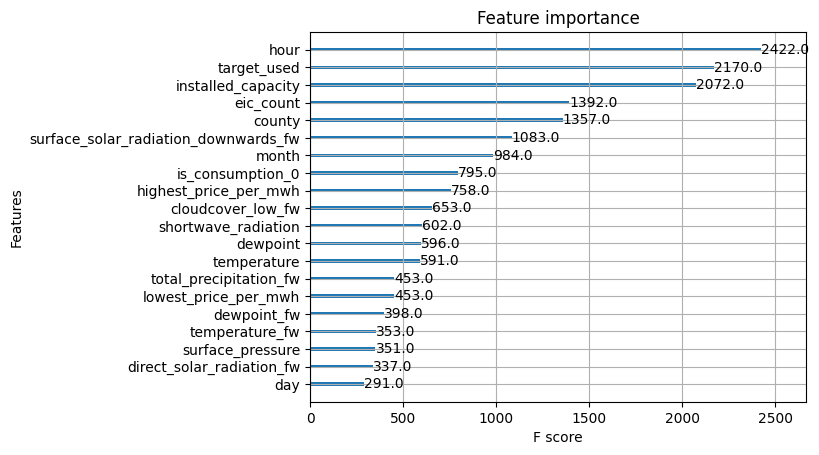

In [9]:
model = Xgb()
model.fit(X_train, y_train, X_test, y_test)
model.importance(features, max_num=20)

## Train the model using the filterd data

[0]	validation_0-mae:218.22513	validation_1-mae:291.79889
[1]	validation_0-mae:187.38369	validation_1-mae:252.03407
[2]	validation_0-mae:159.07641	validation_1-mae:215.80123
[3]	validation_0-mae:143.51202	validation_1-mae:194.25412
[4]	validation_0-mae:128.41453	validation_1-mae:174.38168
[5]	validation_0-mae:112.90421	validation_1-mae:153.46647
[6]	validation_0-mae:99.88598	validation_1-mae:137.76749
[7]	validation_0-mae:91.51133	validation_1-mae:126.15272
[8]	validation_0-mae:86.00801	validation_1-mae:117.39496
[9]	validation_0-mae:81.95409	validation_1-mae:111.42253
[10]	validation_0-mae:79.78169	validation_1-mae:107.61001
[11]	validation_0-mae:78.65113	validation_1-mae:105.34063
[12]	validation_0-mae:77.05624	validation_1-mae:101.31911
[13]	validation_0-mae:76.88737	validation_1-mae:101.12137
[14]	validation_0-mae:75.92538	validation_1-mae:99.76982
[15]	validation_0-mae:75.62221	validation_1-mae:99.46657
[16]	validation_0-mae:75.06295	validation_1-mae:98.45180
[17]	validation_0-mae

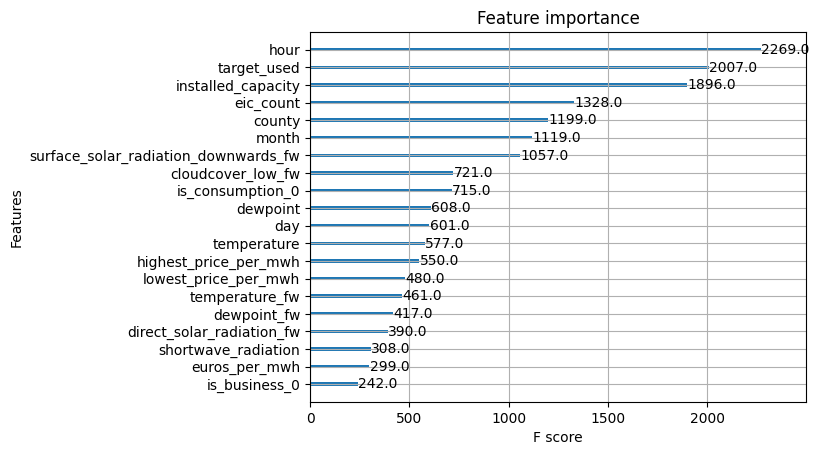

In [10]:
model_sl = Xgb()
model_sl.fit(X_train_sl, y_train_sl, X_test_sl, y_test_sl)
model_sl.importance(features_sl, max_num=20)

# Predict

In [11]:
# 导入api
import enefit
env = enefit.make_env()
iter_test = env.iter_test()

In [12]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    test = test[test_cols]
    revealed_targets = revealed_targets[train_history_cols]
    client = client[client_cols]
    historical_weather = historical_weather[historical_cols]
    forecast_weather = forecast_weather[forecast_cols]
    electricity_prices = electricity_prices[electricity_cols]
    gas_prices = gas_prices[gas_cols]
    station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv', 
                          usecols=station_cols)

    X= load_data(test, revealed_targets, client, gas_prices, electricity_prices,
                             historical_weather, forecast_weather, station, is_train=False)
    target = model.predict(X)
    sample_prediction['target'] = target
    print(sample_prediction)
    # 提交
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/tmp/ipykernel_724/2099679347.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'prediction_datetime': 'datetime'}, inplace=True)
/tmp/ipykernel_724/2099679347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data[col].apply(lambda x: x.year)
/tmp/ipykernel_724/2099679347.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

X.shape (3120, 45)
       row_id        target
0     2005872  2.152477e+00
1     2005873  4.534133e+02
2     2005874  3.872795e-36
3     2005875  3.890321e+00
4     2005876  1.223648e+01
...       ...           ...
3115  2008987  1.976525e+02
3116  2008988  3.872795e-36
3117  2008989  4.336918e+01
3118  2008990  3.872795e-36
3119  2008991  3.112062e+02

[3120 rows x 2 columns]
X.shape (3120, 45)


/tmp/ipykernel_724/2099679347.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_history['datetime'] = train_history['datetime'].apply(lambda x: x + pd.Timedelta(2, 'D'))
/tmp/ipykernel_724/2099679347.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_history.rename(columns={'target': 'target_used'}, inplace=True)
/tmp/ipykernel_724/2099679347.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

       row_id        target
0     2008992  5.832534e-01
1     2008993  4.809246e+02
2     2008994  3.872795e-36
3     2008995  3.906585e+00
4     2008996  3.944651e+00
...       ...           ...
3115  2012107  1.973922e+02
3116  2012108  3.872795e-36
3117  2012109  4.788412e+01
3118  2012110  3.872795e-36
3119  2012111  3.166364e+02

[3120 rows x 2 columns]
X.shape (3120, 45)
       row_id        target
0     2012112 -2.249028e+00
1     2012113  5.855213e+02
2     2012114  3.872795e-36
3     2012115  3.067049e+00
4     2012116 -3.786364e+00
...       ...           ...
3115  2015227  1.747835e+02
3116  2015228  3.872795e-36
3117  2015229  4.343122e+01
3118  2015230  3.872795e-36
3119  2015231  2.845497e+02

[3120 rows x 2 columns]


/tmp/ipykernel_724/2099679347.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['latitude'] = forecast_weather['latitude'].astype(float)            # 转为float类型才能取一位小数
/tmp/ipykernel_724/2099679347.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather['longitude'] = forecast_weather['longitude'].astype(float)
/tmp/ipykernel_724/2099679347.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

X.shape (3120, 45)
       row_id        target
0     2015232  2.932737e-01
1     2015233  4.363892e+02
2     2015234  3.872795e-36
3     2015235  3.321845e+00
4     2015236  1.140025e+01
...       ...           ...
3115  2018347  1.949669e+02
3116  2018348  3.872795e-36
3117  2018349  4.208566e+01
3118  2018350  3.872795e-36
3119  2018351  3.017855e+02

[3120 rows x 2 columns]
